In [1]:
# mount google drive to see repository
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/Capstone/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


**Note**: This notebook is very experimental for prototyping. There is still a lot to do to make it work nicely.

In [2]:
!pip install onedrivedownloader pyyaml h5py torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# basic needs
from onedrivedownloader import download
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# custom utilities
from utils.make_autoencoder_dataset import create_ae_data_list, AutoencoderMRIDataset, ToTensor
from models.autoencoder import Autoencoder, autoencoder_training_loop

# PyTorch
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
# https://github.com/sksq96/pytorch-summary
from torchsummary import summary

## Load the training and validation data sets

In [4]:
# define global vars
DATA_DIR = "/content/data/"  # places this in colab runtime storage instead of gdrive
!mkdir $DATA_DIR
IMG_REDUCED_DIR = os.path.join(DATA_DIR, "data", "images_annot_reduced_norm")
# IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EfqrvokObOJEhovsqLl_sscBgplo836OUdN5kJzAYqPZyg"
IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EccpxJhE8T5BgDkvbgUr6kIBPG0Nx9dneBeaqPPZ0YlZhw"
IMAGES_ANNOT_REDUCED_FN = "images_annot_reduced.zip"
STRUCT_SCANS = ["T1", "T2", "T1GD", "FLAIR"]

# download the reduced dataset if the files have not already been downloaded
if not os.path.exists(IMG_REDUCED_DIR):
    download(IMAGES_ANNOT_REDUCED_URL, filename=os.path.join(DATA_DIR, IMAGES_ANNOT_REDUCED_FN))

mkdir: cannot create directory ‘/content/data/’: File exists


## PyTorch

### Create a custom data set and dataloader

In [5]:
# Create a data list
create_ae_data_list(data_dir=IMG_REDUCED_DIR)

Number of unique samples: 147


In [6]:
# create a custom data set for use with PyTorch DataLoader
custom_ae_mri_data = AutoencoderMRIDataset(
    data_dir=IMG_REDUCED_DIR, 
    data_list_fn=os.path.join(IMG_REDUCED_DIR, "data_list.txt"),
    transforms=transforms.Compose([ToTensor()])
)

In [7]:
custom_ae_mri_data[0]

{'vol': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,


In [8]:
# confirm the shape of the tensor, expect CHWZ
custom_ae_mri_data[0]['vol'].shape

torch.Size([4, 163, 193, 146])

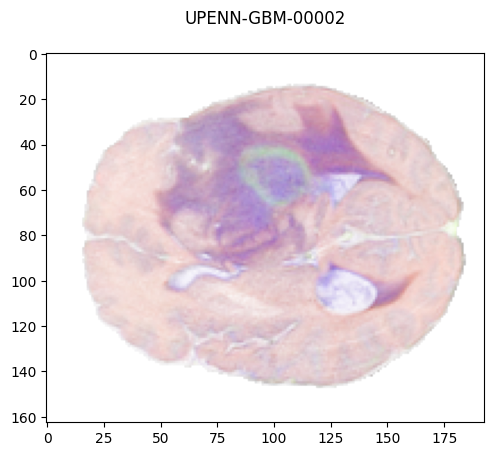

In [9]:
# display the first image
plt.imshow(custom_ae_mri_data[0]['vol'].numpy().transpose((1, 2, 3, 0))[:, :, 73, :])
with open(os.path.join(IMG_REDUCED_DIR, "data_list.txt"), 'r') as file:
    plt.title(file.readline());

In [7]:
# set up data loader
batch_size = 1
dataloader = DataLoader(custom_ae_mri_data, batch_size=batch_size, shuffle=True)

In [11]:
# iterate over each batch and inspect the size is as expected
for i_batch, sampled_batch in enumerate(dataloader):
    print(i_batch, sampled_batch['vol'].size())

0 torch.Size([1, 4, 163, 193, 146])
1 torch.Size([1, 4, 163, 193, 146])
2 torch.Size([1, 4, 163, 193, 146])
3 torch.Size([1, 4, 163, 193, 146])
4 torch.Size([1, 4, 163, 193, 146])
5 torch.Size([1, 4, 163, 193, 146])
6 torch.Size([1, 4, 163, 193, 146])
7 torch.Size([1, 4, 163, 193, 146])
8 torch.Size([1, 4, 163, 193, 146])
9 torch.Size([1, 4, 163, 193, 146])
10 torch.Size([1, 4, 163, 193, 146])
11 torch.Size([1, 4, 163, 193, 146])
12 torch.Size([1, 4, 163, 193, 146])
13 torch.Size([1, 4, 163, 193, 146])
14 torch.Size([1, 4, 163, 193, 146])
15 torch.Size([1, 4, 163, 193, 146])
16 torch.Size([1, 4, 163, 193, 146])
17 torch.Size([1, 4, 163, 193, 146])
18 torch.Size([1, 4, 163, 193, 146])
19 torch.Size([1, 4, 163, 193, 146])
20 torch.Size([1, 4, 163, 193, 146])
21 torch.Size([1, 4, 163, 193, 146])
22 torch.Size([1, 4, 163, 193, 146])
23 torch.Size([1, 4, 163, 193, 146])
24 torch.Size([1, 4, 163, 193, 146])
25 torch.Size([1, 4, 163, 193, 146])
26 torch.Size([1, 4, 163, 193, 146])
27 torch.Si

These results match what is expected, and most importantly, the memory has not been significantly used up since each volume is being accessed on-demand instead of all-at-once.

### Train autoencoder

In [8]:
# Instantiate the model
model = Autoencoder()

In [9]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 3, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=same)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose3d(3, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): Sigmoid()
  )
)


In [10]:
# get model summary using torchsummary (similar to keras api summary for TF2)
# need to send model to device first or else there will be a mismatch in dtypes
# https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte
if torch.cuda.is_available():
    summary(model.cuda(), input_size=(4, 163, 193, 146))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 3, 163, 193, 146]              15
              ReLU-2     [-1, 3, 163, 193, 146]               0
   ConvTranspose3d-3     [-1, 4, 163, 193, 146]              16
           Sigmoid-4     [-1, 4, 163, 193, 146]               0
Total params: 31
Trainable params: 31
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 70.08
Forward/backward pass size (MB): 490.59
Params size (MB): 0.00
Estimated Total Size (MB): 560.67
----------------------------------------------------------------


In [11]:
# specify the loss function
loss_fn = nn.MSELoss()

# create an optimizer
optimizer = torch.optim.Adam(model.parameters())  # use default lr=0.001

In [12]:
# call the training loop
fitted = autoencoder_training_loop(model, loss_fn, optimizer, dataloader, nepochs=10)

Epoch 1/10 - Loss: 0.14245353639125824
Epoch 2/10 - Loss: 0.08208400756120682
Epoch 3/10 - Loss: 0.059926826506853104
Epoch 4/10 - Loss: 0.04511404410004616
Epoch 5/10 - Loss: 0.02876432240009308
Epoch 6/10 - Loss: 0.019390083849430084
Epoch 7/10 - Loss: 0.013309942558407784
Epoch 8/10 - Loss: 0.017994344234466553
Epoch 9/10 - Loss: 0.014095942489802837
Epoch 10/10 - Loss: 0.008230105973780155


In [20]:
# let's see what a reconstructed image looks like for the first input
reconstructed = model(custom_ae_mri_data[0]['vol'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float))

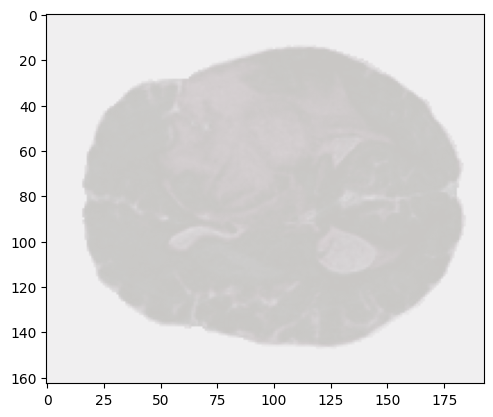

In [24]:
plt.imshow(reconstructed.cpu().detach().numpy().transpose(1, 2, 3, 0)[:, :, 73, :]);

In [25]:
# what is the latent space representation?
latent_space_rep = model.encoder(custom_ae_mri_data[0]['vol'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float))

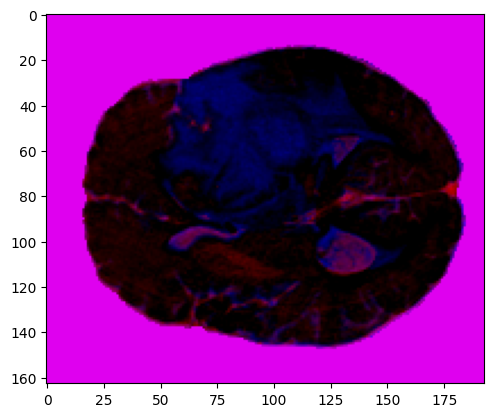

In [26]:
# visualize
plt.imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, :]);